In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


0     -0.025547
1      0.092241
2      0.091614
3     -0.029861
4     -0.081061
5     -0.081246
6      0.075370
7     -0.018363
8     -0.065202
9      0.064017
10     0.035250
11    -0.054299
12    -0.080261
13     0.032733
14     0.039559
15     0.112890
16     0.014132
17    -0.040457
18    -0.143370
19    -0.080158
20    -0.046180
21     0.160100
22     0.036908
23    -0.030857
24    -0.161610
25    -0.074868
26     0.005449
27     0.152760
28     0.140540
29    -0.030355
         ...   
702   -0.042584
703   -0.030396
704   -0.001803
705    0.018636
706   -0.016862
707    0.022332
708   -0.035619
709    0.000859
710    0.048474
711    0.129500
712    0.167110
713    0.182690
714   -0.007033
715   -0.275650
716   -0.291690
717   -0.140830
718    0.089041
719    0.410710
720    0.431360
721    0.436000
722    0.304370
723    0.114330
724   -0.056745
725   -0.231500
726   -0.332560
727   -0.482560
728   -0.501440
729   -0.495780
730   -0.458700
731   -0.377350
Name: f0, Length: 732, d

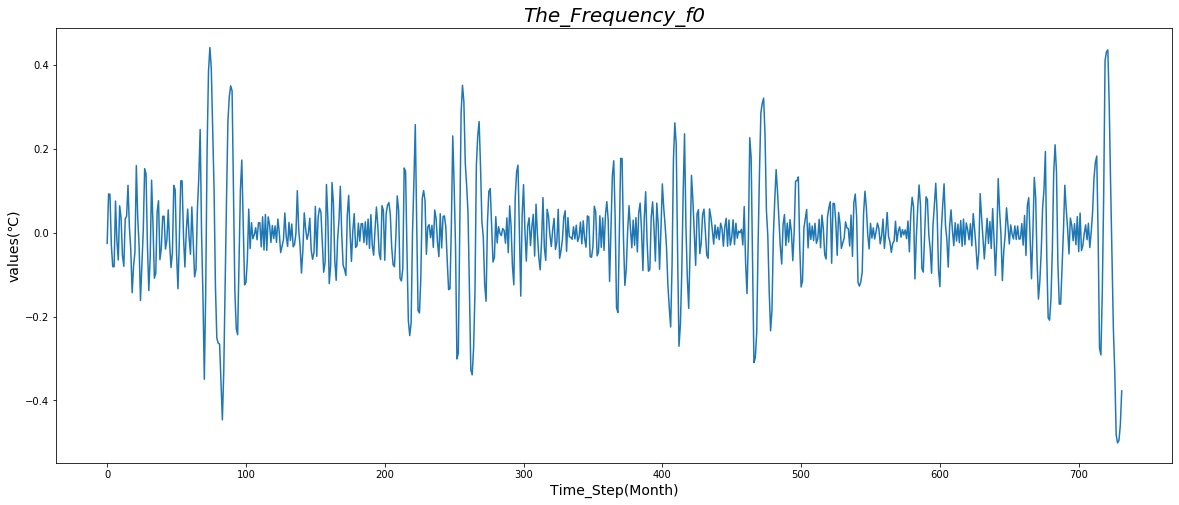

[[[-2.5547e-02]
  [ 9.2241e-02]
  [ 9.1614e-02]
  [-2.9861e-02]
  [-8.1061e-02]
  [-8.1246e-02]
  [ 7.5370e-02]
  [-1.8363e-02]
  [-6.5202e-02]
  [ 6.4017e-02]
  [ 3.5250e-02]
  [-5.4299e-02]]

 [[-8.0261e-02]
  [ 3.2733e-02]
  [ 3.9559e-02]
  [ 1.1289e-01]
  [ 1.4132e-02]
  [-4.0457e-02]
  [-1.4337e-01]
  [-8.0158e-02]
  [-4.6180e-02]
  [ 1.6010e-01]
  [ 3.6908e-02]
  [-3.0857e-02]]

 [[-1.6161e-01]
  [-7.4868e-02]
  [ 5.4492e-03]
  [ 1.5276e-01]
  [ 1.4054e-01]
  [-3.0355e-02]
  [-1.3808e-01]
  [-5.8738e-02]
  [ 1.2519e-01]
  [ 1.9747e-02]
  [-1.0855e-01]
  [-9.7296e-02]]

 [[ 4.9602e-02]
  [ 7.6171e-02]
  [-6.4388e-02]
  [-3.7326e-02]
  [ 3.8834e-02]
  [ 3.9240e-02]
  [-3.9069e-02]
  [-1.8257e-02]
  [ 5.4259e-02]
  [-2.5882e-02]
  [-8.3007e-02]
  [-4.7521e-02]]

 [[ 1.1258e-01]
  [ 1.0203e-01]
  [-5.0122e-02]
  [-1.3377e-01]
  [-1.6454e-02]
  [ 1.2364e-01]
  [ 1.2345e-01]
  [-1.0158e-02]
  [-8.2005e-02]
  [ 4.5278e-03]
  [ 5.6274e-02]
  [-1.0434e-02]]

 [[-5.1485e-02]
  [ 6.1355e-02

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 8s - loss: 0.0108
Epoch 2/200
 - 2s - loss: 0.0108
Epoch 3/200
 - 2s - loss: 0.0107
Epoch 4/200
 - 2s - loss: 0.0107
Epoch 5/200
 - 2s - loss: 0.0107
Epoch 6/200
 - 2s - loss: 0.0107
Epoch 7/200
 - 2s - loss: 0.0107
Epoch 8/200
 - 2s - loss: 0.0107
Epoch 9/200
 - 2s - loss: 0.0106
Epoch 10/200
 - 2s - loss: 0.0106
Epoch 11/200
 - 2s - loss: 0.0104
Epoch 12/200
 - 2s - loss: 0.0103
Epoch 13/200
 - 2s - loss: 0.0101
Epoch 14/200
 - 2s - loss: 0.0097
Epoch 15/200
 - 2s - loss: 0.0094
Epoch 16/200
 - 2s - loss: 0.0092
Epoch 17/200
 - 2s - loss: 0.0092
Epoch 18/200
 - 2s - loss: 0.0089
Epoch 19/200
 - 2s - loss: 0.0086
Epoch 20/200
 - 2s - loss: 0.0084
Epoch 21/200
 - 2s - loss: 0.0083
Epoch 22/200
 - 2s - loss: 0.0084
Epoch 23/200
 - 2s - loss: 0.0083
Epoch 24/200
 - 2s - loss: 0.0082
Epoch 25/200
 - 2s - loss: 0.0080
Epoch 26/200
 - 2s - loss: 0.0079
Epoch 27/200
 - 2s - loss: 0.0077
Epoch 28/200
 - 2s - loss: 0.0076
Epoch 29/

(58, 12)


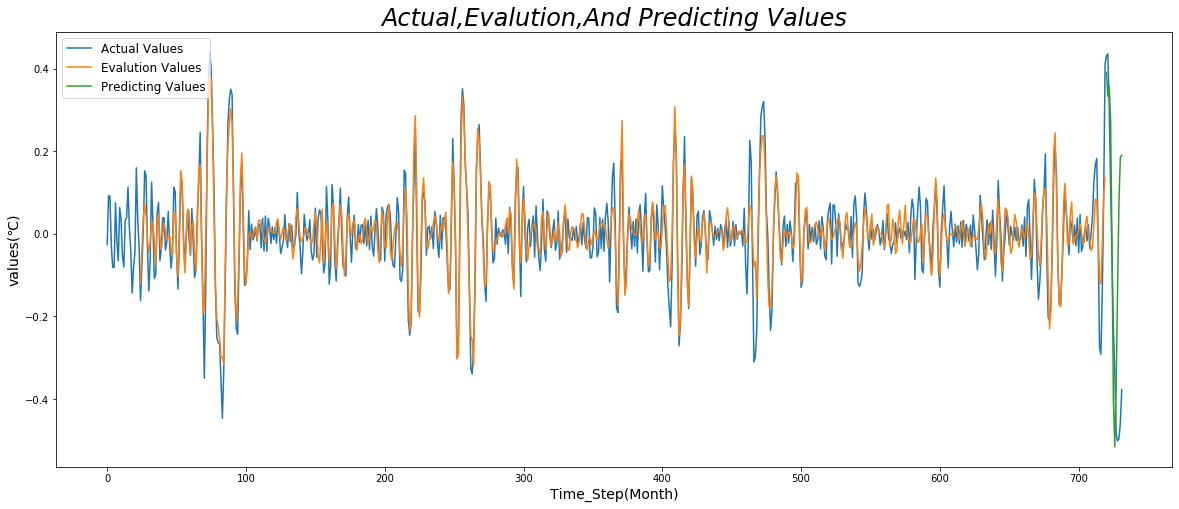

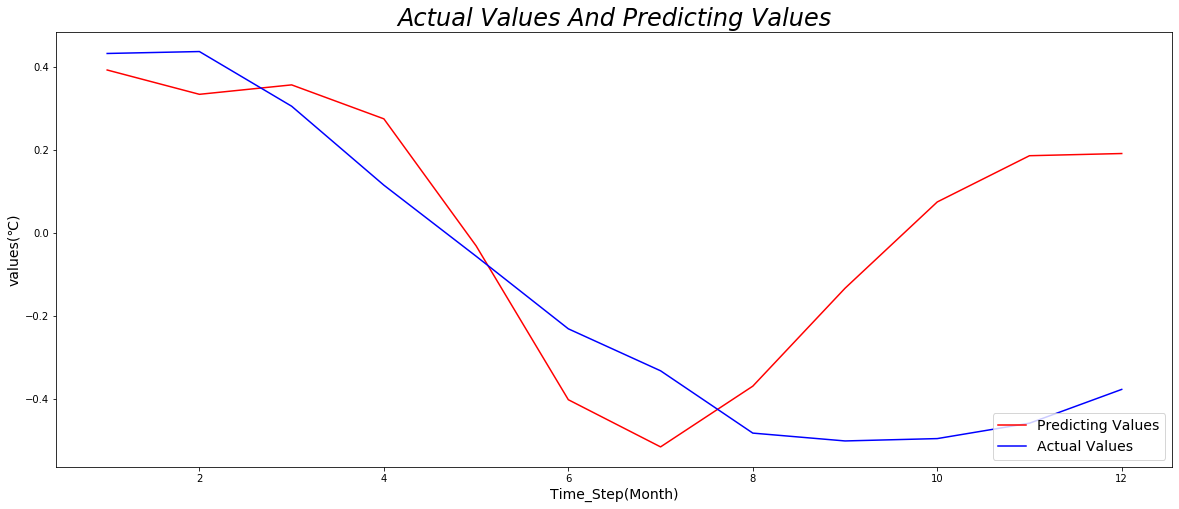

0     -0.294540
1     -0.206260
2     -0.114940
3     -0.018285
4      0.092434
5      0.236340
6      0.407510
7      0.512940
8      0.455400
9      0.206520
10    -0.097637
11    -0.351990
12    -0.478850
13    -0.451500
14    -0.319580
15    -0.149650
16     0.002985
17     0.128160
18     0.224470
19     0.283560
20     0.306910
21     0.296920
22     0.250800
23     0.176900
24     0.086898
25    -0.006406
26    -0.085830
27    -0.131520
28    -0.123820
29    -0.071080
         ...   
702    0.642710
703    0.651090
704    0.517000
705    0.269650
706   -0.037233
707   -0.328340
708   -0.525900
709   -0.615760
710   -0.610160
711   -0.528340
712   -0.390740
713   -0.216030
714   -0.018192
715    0.179080
716    0.347050
717    0.474100
718    0.550870
719    0.566740
720    0.513840
721    0.403370
722    0.251160
723    0.074913
724   -0.107170
725   -0.276900
726   -0.416050
727   -0.506440
728   -0.532560
729   -0.492060
730   -0.395240
731   -0.257820
Name: f1, Length: 732, d

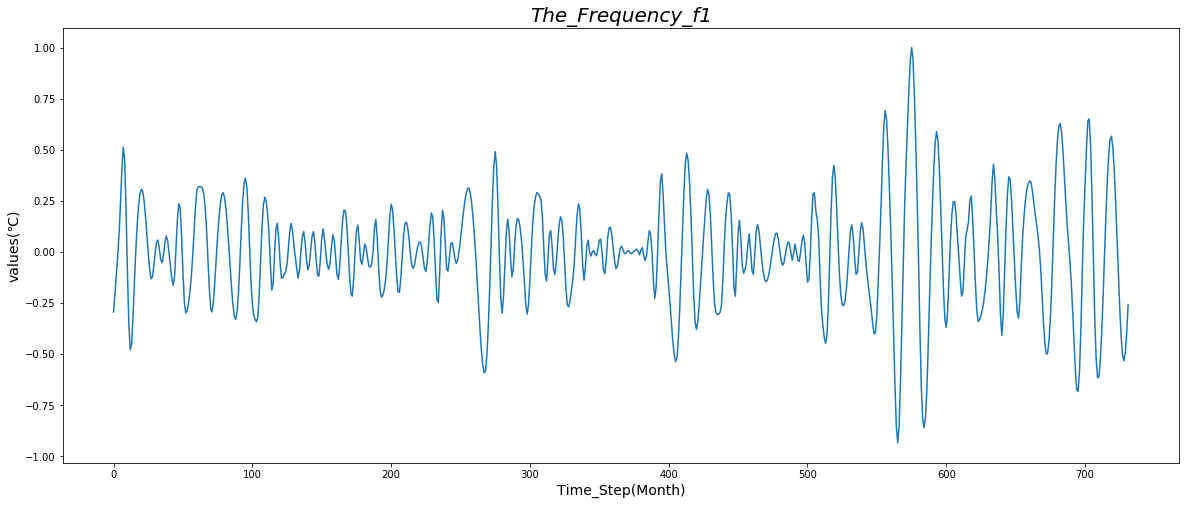

[[[-2.9454e-01]
  [-2.0626e-01]
  [-1.1494e-01]
  [-1.8285e-02]
  [ 9.2434e-02]
  [ 2.3634e-01]
  [ 4.0751e-01]
  [ 5.1294e-01]
  [ 4.5540e-01]
  [ 2.0652e-01]
  [-9.7637e-02]
  [-3.5199e-01]]

 [[-4.7885e-01]
  [-4.5150e-01]
  [-3.1958e-01]
  [-1.4965e-01]
  [ 2.9850e-03]
  [ 1.2816e-01]
  [ 2.2447e-01]
  [ 2.8356e-01]
  [ 3.0691e-01]
  [ 2.9692e-01]
  [ 2.5080e-01]
  [ 1.7690e-01]]

 [[ 8.6898e-02]
  [-6.4059e-03]
  [-8.5830e-02]
  [-1.3152e-01]
  [-1.2382e-01]
  [-7.1080e-02]
  [-3.0445e-03]
  [ 4.8778e-02]
  [ 5.8154e-02]
  [ 1.5810e-02]
  [-3.7963e-02]
  [-5.2927e-02]]

 [[-1.2426e-02]
  [ 4.7069e-02]
  [ 7.8590e-02]
  [ 5.3272e-02]
  [-5.8918e-03]
  [-6.9886e-02]
  [-1.3140e-01]
  [-1.6388e-01]
  [-1.1630e-01]
  [ 1.6081e-02]
  [ 1.5718e-01]
  [ 2.3609e-01]]

 [[ 2.1549e-01]
  [ 8.3197e-02]
  [-9.7596e-02]
  [-2.4477e-01]
  [-2.9853e-01]
  [-2.8754e-01]
  [-2.5153e-01]
  [-1.9811e-01]
  [-1.2294e-01]
  [-2.2837e-02]
  [ 9.6141e-02]
  [ 2.1869e-01]]

 [[ 3.0174e-01]
  [ 3.1849e-01

Epoch 1/200
 - 9s - loss: 0.0635
Epoch 2/200
 - 2s - loss: 0.0598
Epoch 3/200
 - 2s - loss: 0.0542
Epoch 4/200
 - 2s - loss: 0.0460
Epoch 5/200
 - 2s - loss: 0.0438
Epoch 6/200
 - 2s - loss: 0.0411
Epoch 7/200
 - 2s - loss: 0.0374
Epoch 8/200
 - 2s - loss: 0.0362
Epoch 9/200
 - 3s - loss: 0.0332
Epoch 10/200
 - 2s - loss: 0.0326
Epoch 11/200
 - 2s - loss: 0.0327
Epoch 12/200
 - 2s - loss: 0.0332
Epoch 13/200
 - 2s - loss: 0.0312
Epoch 14/200
 - 2s - loss: 0.0296
Epoch 15/200
 - 2s - loss: 0.0290
Epoch 16/200
 - 2s - loss: 0.0290
Epoch 17/200
 - 2s - loss: 0.0306
Epoch 18/200
 - 2s - loss: 0.0289
Epoch 19/200
 - 2s - loss: 0.0291
Epoch 20/200
 - 2s - loss: 0.0269
Epoch 21/200
 - 2s - loss: 0.0269
Epoch 22/200
 - 2s - loss: 0.0263
Epoch 23/200
 - 2s - loss: 0.0252
Epoch 24/200
 - 2s - loss: 0.0250
Epoch 25/200
 - 2s - loss: 0.0252
Epoch 26/200
 - 2s - loss: 0.0250
Epoch 27/200
 - 2s - loss: 0.0256
Epoch 28/200
 - 2s - loss: 0.0255
Epoch 29/200
 - 2s - loss: 0.0252
Epoch 30/200
 - 2s - lo

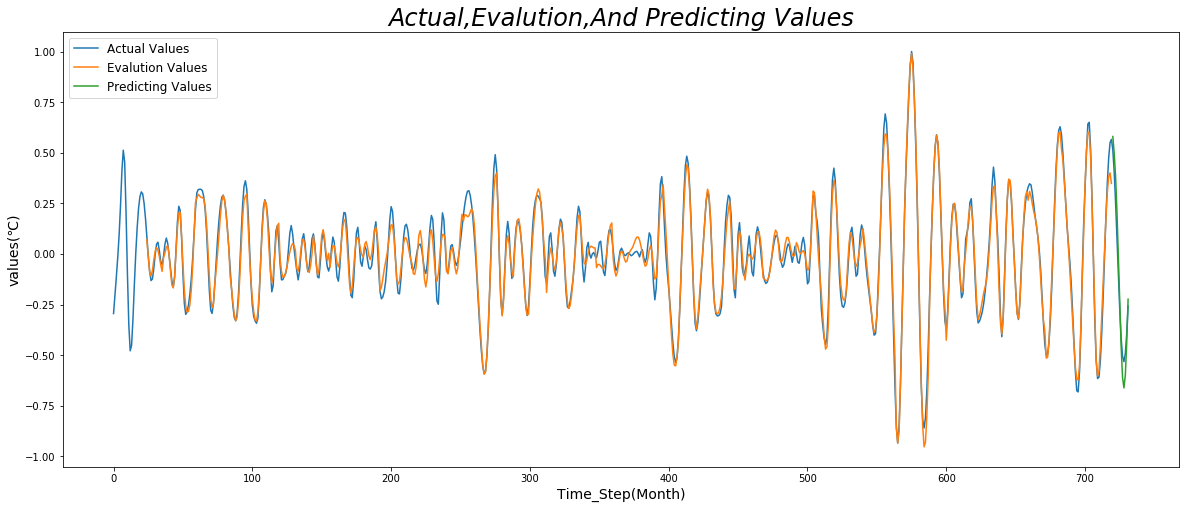

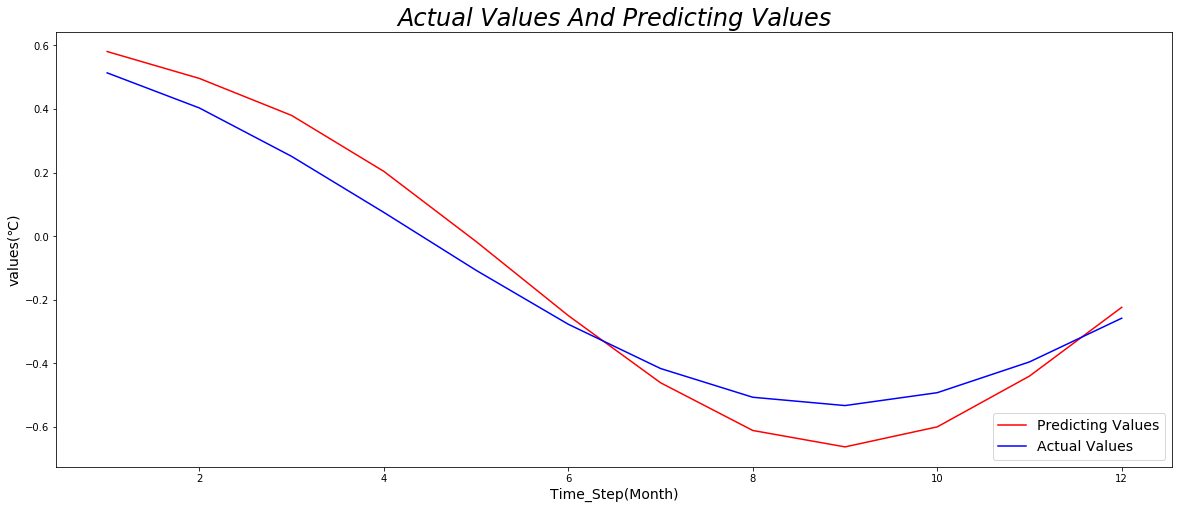

0     -0.438890
1     -0.456720
2     -0.466010
3     -0.466450
4     -0.457420
5     -0.438230
6     -0.408210
7     -0.366670
8     -0.313070
9     -0.247670
10    -0.171950
11    -0.087650
12     0.003699
13     0.100570
14     0.198250
15     0.291170
16     0.373790
17     0.440530
18     0.485840
19     0.504150
20     0.489910
21     0.439690
22     0.358500
23     0.253460
24     0.131690
25     0.000284
26    -0.133640
27    -0.262960
28    -0.380460
29    -0.478240
         ...   
702   -0.747490
703   -0.681200
704   -0.588300
705   -0.473200
706   -0.341580
707   -0.199120
708   -0.051520
709    0.095783
710    0.238560
711    0.374040
712    0.499750
713    0.613220
714    0.711980
715    0.793560
716    0.855500
717    0.895320
718    0.910510
719    0.898810
720    0.860330
721    0.798150
722    0.716020
723    0.617670
724    0.506840
725    0.387250
726    0.262660
727    0.136790
728    0.013370
729   -0.104050
730   -0.212760
731   -0.310570
Name: f2, Length: 732, d

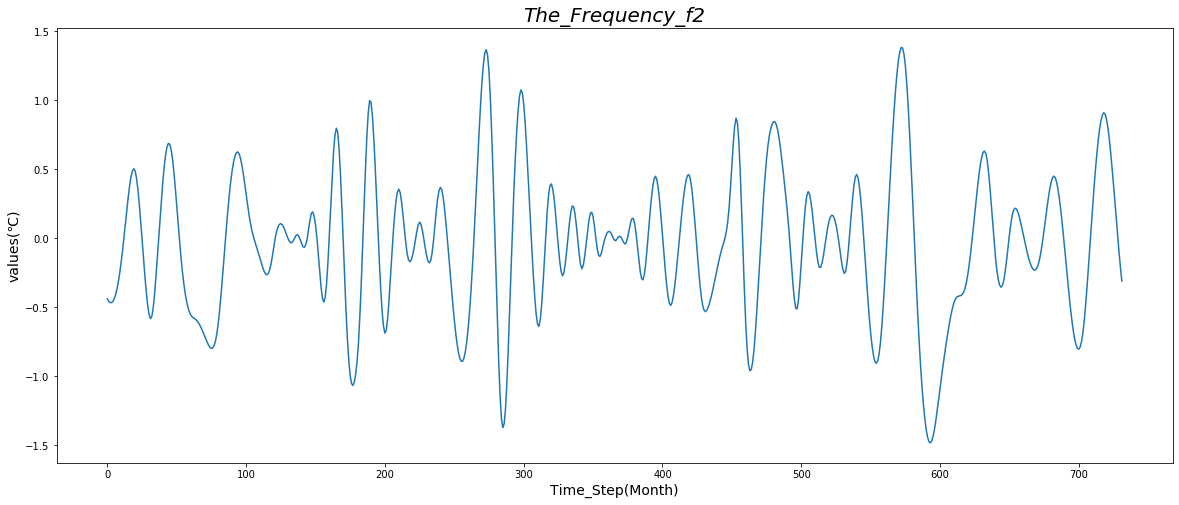

[[[-4.3889e-01]
  [-4.5672e-01]
  [-4.6601e-01]
  [-4.6645e-01]
  [-4.5742e-01]
  [-4.3823e-01]
  [-4.0821e-01]
  [-3.6667e-01]
  [-3.1307e-01]
  [-2.4767e-01]
  [-1.7195e-01]
  [-8.7650e-02]]

 [[ 3.6991e-03]
  [ 1.0057e-01]
  [ 1.9825e-01]
  [ 2.9117e-01]
  [ 3.7379e-01]
  [ 4.4053e-01]
  [ 4.8584e-01]
  [ 5.0415e-01]
  [ 4.8991e-01]
  [ 4.3969e-01]
  [ 3.5850e-01]
  [ 2.5346e-01]]

 [[ 1.3169e-01]
  [ 2.8436e-04]
  [-1.3364e-01]
  [-2.6296e-01]
  [-3.8046e-01]
  [-4.7824e-01]
  [-5.4803e-01]
  [-5.8184e-01]
  [-5.7069e-01]
  [-5.1160e-01]
  [-4.1193e-01]
  [-2.8498e-01]]

 [[-1.4410e-01]
  [ 2.5337e-03]
  [ 1.4806e-01]
  [ 2.8598e-01]
  [ 4.1120e-01]
  [ 5.1893e-01]
  [ 6.0420e-01]
  [ 6.6199e-01]
  [ 6.8813e-01]
  [ 6.8186e-01]
  [ 6.4337e-01]
  [ 5.7378e-01]]

 [[ 4.7821e-01]
  [ 3.6393e-01]
  [ 2.3850e-01]
  [ 1.0950e-01]
  [-1.5500e-02]
  [-1.2986e-01]
  [-2.3097e-01]
  [-3.1827e-01]
  [-3.9149e-01]
  [-4.5060e-01]
  [-4.9659e-01]
  [-5.3066e-01]]

 [[-5.5404e-01]
  [-5.6837e-01

Epoch 1/200
 - 10s - loss: 0.2621
Epoch 2/200
 - 2s - loss: 0.2376
Epoch 3/200
 - 2s - loss: 0.2302
Epoch 4/200
 - 2s - loss: 0.2039
Epoch 5/200
 - 2s - loss: 0.1688
Epoch 6/200
 - 2s - loss: 0.1237
Epoch 7/200
 - 2s - loss: 0.1050
Epoch 8/200
 - 2s - loss: 0.1105
Epoch 9/200
 - 2s - loss: 0.0888
Epoch 10/200
 - 2s - loss: 0.0847
Epoch 11/200
 - 2s - loss: 0.0792
Epoch 12/200
 - 2s - loss: 0.0771
Epoch 13/200
 - 2s - loss: 0.0690
Epoch 14/200
 - 2s - loss: 0.0720
Epoch 15/200
 - 2s - loss: 0.0672
Epoch 16/200
 - 2s - loss: 0.0653
Epoch 17/200
 - 2s - loss: 0.0692
Epoch 18/200
 - 2s - loss: 0.0607
Epoch 19/200
 - 2s - loss: 0.0584
Epoch 20/200
 - 2s - loss: 0.0591
Epoch 21/200
 - 2s - loss: 0.0533
Epoch 22/200
 - 2s - loss: 0.0567
Epoch 23/200
 - 2s - loss: 0.0501
Epoch 24/200
 - 2s - loss: 0.0490
Epoch 25/200
 - 2s - loss: 0.0489
Epoch 26/200
 - 2s - loss: 0.0472
Epoch 27/200
 - 2s - loss: 0.0501
Epoch 28/200
 - 2s - loss: 0.0505
Epoch 29/200
 - 2s - loss: 0.0436
Epoch 30/200
 - 2s - l

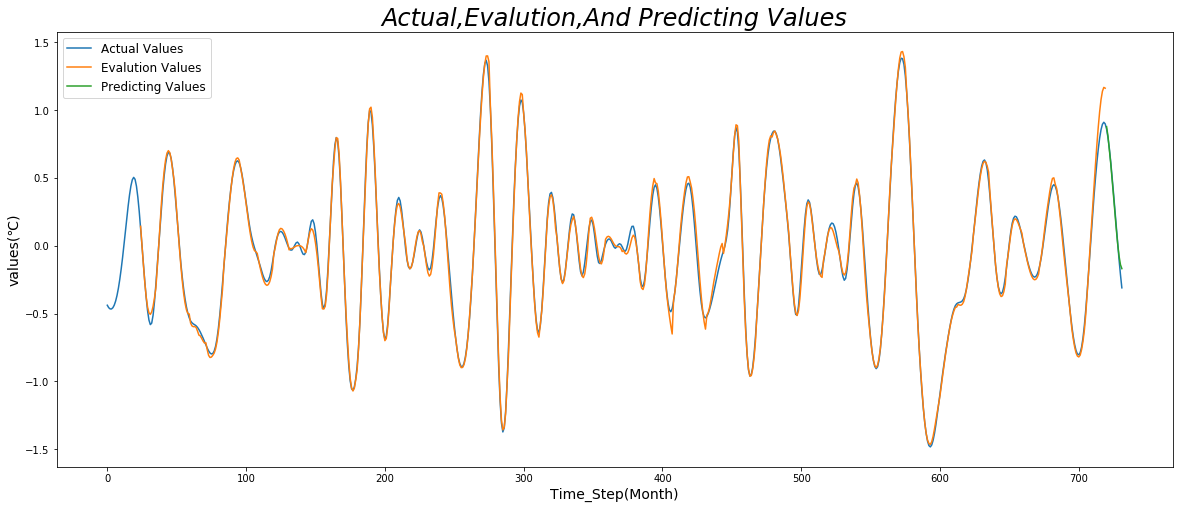

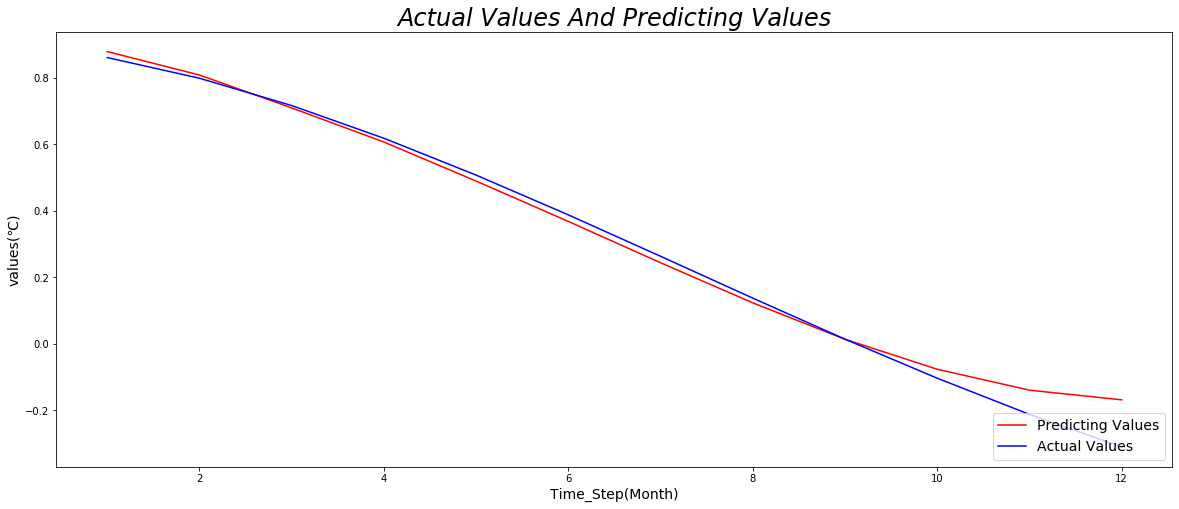

0     -0.538450
1     -0.526230
2     -0.507350
3     -0.481980
4     -0.450610
5     -0.413780
6     -0.372030
7     -0.325890
8     -0.275900
9     -0.222610
10    -0.166550
11    -0.108270
12    -0.048294
13     0.012829
14     0.074562
15     0.136370
16     0.197700
17     0.258030
18     0.316810
19     0.373510
20     0.427580
21     0.478490
22     0.525830
23     0.569200
24     0.608230
25     0.642540
26     0.671750
27     0.695490
28     0.713370
29     0.725020
         ...   
702   -0.002868
703    0.020229
704    0.042903
705    0.064891
706    0.085936
707    0.105780
708    0.124150
709    0.140810
710    0.155480
711    0.167900
712    0.177820
713    0.184970
714    0.189050
715    0.189810
716    0.186940
717    0.180130
718    0.169100
719    0.153880
720    0.134980
721    0.113050
722    0.088710
723    0.062607
724    0.035372
725    0.007642
726   -0.019950
727   -0.046766
728   -0.072172
729   -0.095532
730   -0.116210
731   -0.133570
Name: f3, Length: 732, d

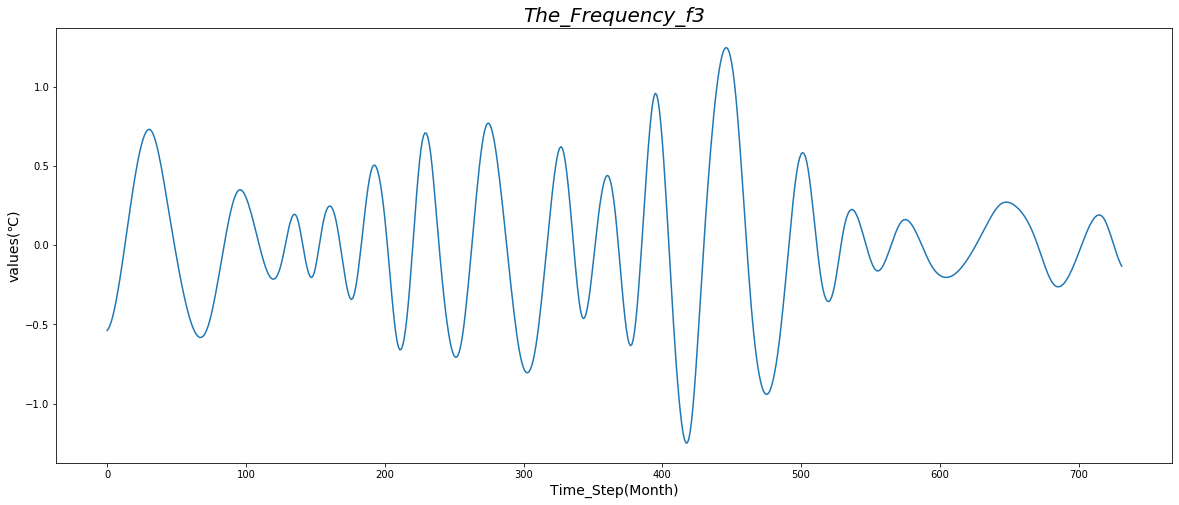

[[[-5.3845e-01]
  [-5.2623e-01]
  [-5.0735e-01]
  [-4.8198e-01]
  [-4.5061e-01]
  [-4.1378e-01]
  [-3.7203e-01]
  [-3.2589e-01]
  [-2.7590e-01]
  [-2.2261e-01]
  [-1.6655e-01]
  [-1.0827e-01]]

 [[-4.8294e-02]
  [ 1.2829e-02]
  [ 7.4562e-02]
  [ 1.3637e-01]
  [ 1.9770e-01]
  [ 2.5803e-01]
  [ 3.1681e-01]
  [ 3.7351e-01]
  [ 4.2758e-01]
  [ 4.7849e-01]
  [ 5.2583e-01]
  [ 5.6920e-01]]

 [[ 6.0823e-01]
  [ 6.4254e-01]
  [ 6.7175e-01]
  [ 6.9549e-01]
  [ 7.1337e-01]
  [ 7.2502e-01]
  [ 7.3005e-01]
  [ 7.2810e-01]
  [ 7.1888e-01]
  [ 7.0263e-01]
  [ 6.7994e-01]
  [ 6.5140e-01]]

 [[ 6.1765e-01]
  [ 5.7930e-01]
  [ 5.3698e-01]
  [ 4.9129e-01]
  [ 4.4287e-01]
  [ 3.9232e-01]
  [ 3.4028e-01]
  [ 2.8736e-01]
  [ 2.3413e-01]
  [ 1.8096e-01]
  [ 1.2808e-01]
  [ 7.5673e-02]]

 [[ 2.3922e-02]
  [-2.6981e-02]
  [-7.6848e-02]
  [-1.2549e-01]
  [-1.7272e-01]
  [-2.1835e-01]
  [-2.6219e-01]
  [-3.0405e-01]
  [-3.4374e-01]
  [-3.8107e-01]
  [-4.1587e-01]
  [-4.4793e-01]]

 [[-4.7707e-01]
  [-5.0310e-01

Epoch 1/200
 - 11s - loss: 0.1640
Epoch 2/200
 - 2s - loss: 0.1232
Epoch 3/200
 - 2s - loss: 0.0845
Epoch 4/200
 - 2s - loss: 0.0651
Epoch 5/200
 - 2s - loss: 0.0563
Epoch 6/200
 - 2s - loss: 0.0391
Epoch 7/200
 - 2s - loss: 0.0343
Epoch 8/200
 - 2s - loss: 0.0247
Epoch 9/200
 - 2s - loss: 0.0196
Epoch 10/200
 - 2s - loss: 0.0171
Epoch 11/200
 - 2s - loss: 0.0199
Epoch 12/200
 - 2s - loss: 0.0141
Epoch 13/200
 - 2s - loss: 0.0125
Epoch 14/200
 - 2s - loss: 0.0180
Epoch 15/200
 - 3s - loss: 0.0201
Epoch 16/200
 - 2s - loss: 0.0139
Epoch 17/200
 - 2s - loss: 0.0162
Epoch 18/200
 - 2s - loss: 0.0128
Epoch 19/200
 - 2s - loss: 0.0135
Epoch 20/200
 - 2s - loss: 0.0169
Epoch 21/200
 - 2s - loss: 0.0103
Epoch 22/200
 - 2s - loss: 0.0110
Epoch 23/200
 - 2s - loss: 0.0104
Epoch 24/200
 - 2s - loss: 0.0091
Epoch 25/200
 - 2s - loss: 0.0089
Epoch 26/200
 - 2s - loss: 0.0082
Epoch 27/200
 - 2s - loss: 0.0069
Epoch 28/200
 - 2s - loss: 0.0073
Epoch 29/200
 - 2s - loss: 0.0086
Epoch 30/200
 - 2s - l

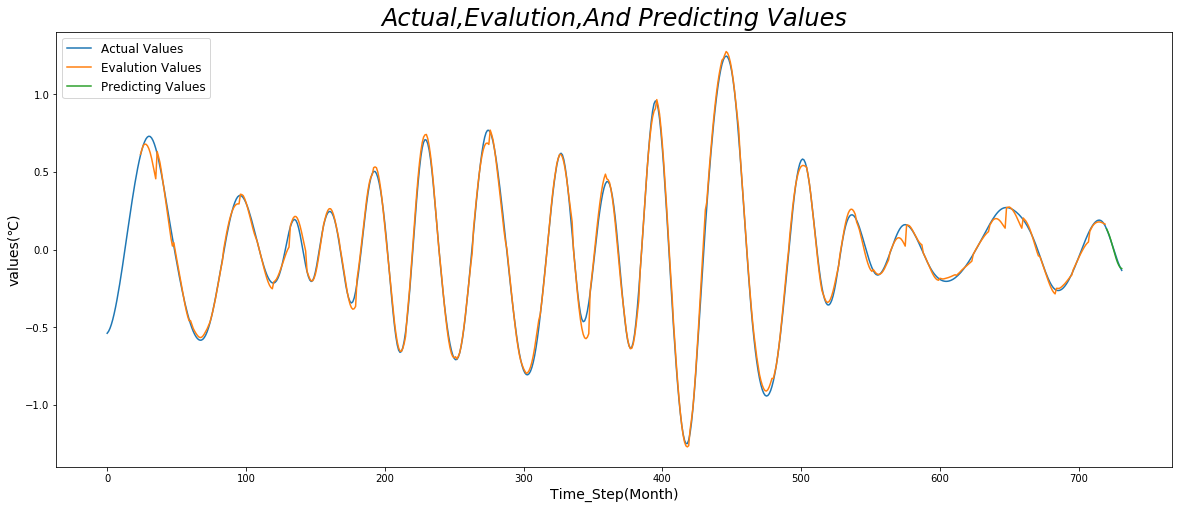

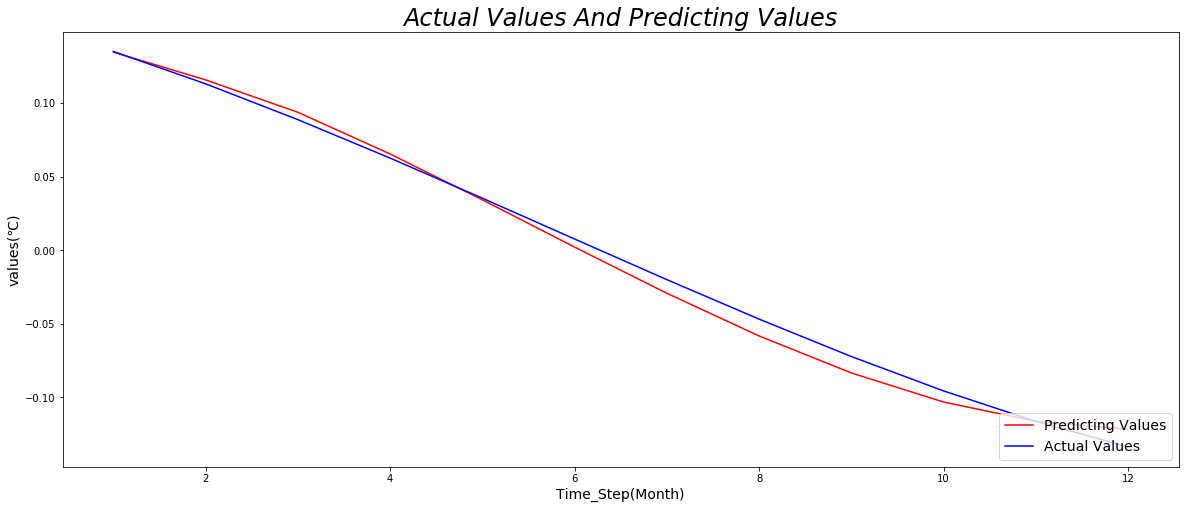

0     -0.215810
1     -0.214380
2     -0.212910
3     -0.211390
4     -0.209820
5     -0.208200
6     -0.206530
7     -0.204810
8     -0.203030
9     -0.201200
10    -0.199310
11    -0.197360
12    -0.195360
13    -0.193290
14    -0.191160
15    -0.188960
16    -0.186700
17    -0.184380
18    -0.181980
19    -0.179520
20    -0.176990
21    -0.174390
22    -0.171710
23    -0.168960
24    -0.166130
25    -0.163230
26    -0.160250
27    -0.157190
28    -0.154050
29    -0.150820
         ...   
702   -0.022300
703   -0.034936
704   -0.047759
705   -0.060765
706   -0.073953
707   -0.087317
708   -0.100860
709   -0.114560
710   -0.128440
711   -0.142480
712   -0.156680
713   -0.171020
714   -0.185480
715   -0.200040
716   -0.214670
717   -0.229300
718   -0.243880
719   -0.258330
720   -0.272600
721   -0.286630
722   -0.300340
723   -0.313690
724   -0.326600
725   -0.339010
726   -0.350860
727   -0.362100
728   -0.372640
729   -0.382440
730   -0.391430
731   -0.399540
Name: f4, Length: 732, d

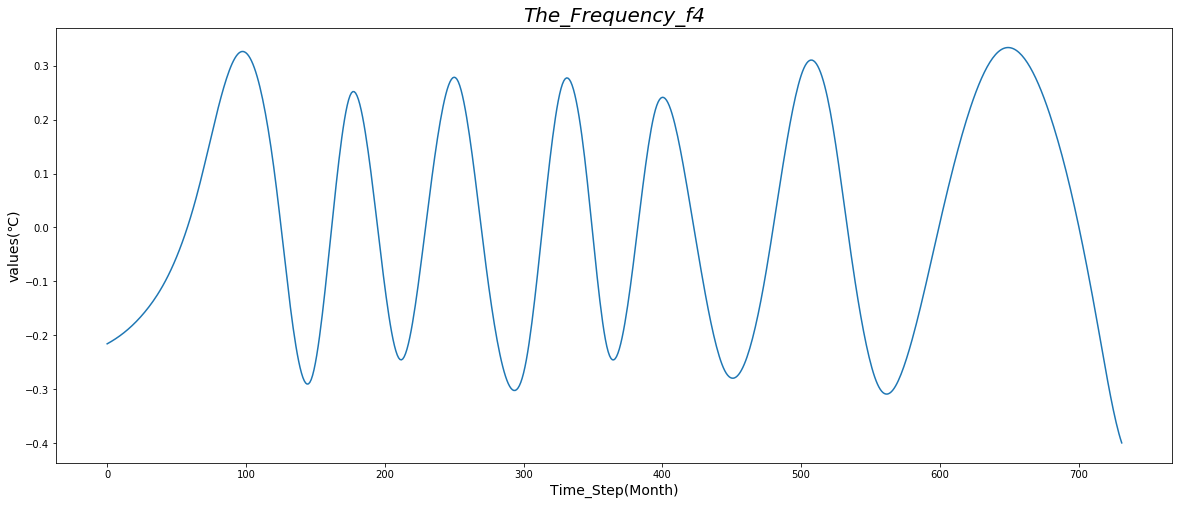

[[[-0.21581  ]
  [-0.21438  ]
  [-0.21291  ]
  [-0.21139  ]
  [-0.20982  ]
  [-0.2082   ]
  [-0.20653  ]
  [-0.20481  ]
  [-0.20303  ]
  [-0.2012   ]
  [-0.19931  ]
  [-0.19736  ]]

 [[-0.19536  ]
  [-0.19329  ]
  [-0.19116  ]
  [-0.18896  ]
  [-0.1867   ]
  [-0.18438  ]
  [-0.18198  ]
  [-0.17952  ]
  [-0.17699  ]
  [-0.17439  ]
  [-0.17171  ]
  [-0.16896  ]]

 [[-0.16613  ]
  [-0.16323  ]
  [-0.16025  ]
  [-0.15719  ]
  [-0.15405  ]
  [-0.15082  ]
  [-0.14752  ]
  [-0.14412  ]
  [-0.14063  ]
  [-0.13703  ]
  [-0.13331  ]
  [-0.12948  ]]

 [[-0.12553  ]
  [-0.12146  ]
  [-0.11725  ]
  [-0.11291  ]
  [-0.10842  ]
  [-0.10379  ]
  [-0.099013 ]
  [-0.094078 ]
  [-0.088983 ]
  [-0.083723 ]
  [-0.078293 ]
  [-0.072689 ]]

 [[-0.066905 ]
  [-0.060937 ]
  [-0.054779 ]
  [-0.048428 ]
  [-0.041877 ]
  [-0.035123 ]
  [-0.028161 ]
  [-0.020985 ]
  [-0.01359  ]
  [-0.0059729]
  [ 0.0018726]
  [ 0.0099509]]

 [[ 0.018267 ]
  [ 0.026826 ]
  [ 0.035632 ]
  [ 0.04469  ]
  [ 0.054005 ]
  [ 0.06358  ]


Epoch 1/200
 - 10s - loss: 0.0283
Epoch 2/200
 - 2s - loss: 0.0099
Epoch 3/200
 - 2s - loss: 0.0049
Epoch 4/200
 - 2s - loss: 0.0039
Epoch 5/200
 - 2s - loss: 0.0025
Epoch 6/200
 - 2s - loss: 0.0023
Epoch 7/200
 - 2s - loss: 0.0015
Epoch 8/200
 - 2s - loss: 0.0011
Epoch 9/200
 - 2s - loss: 0.0011
Epoch 10/200
 - 2s - loss: 0.0012
Epoch 11/200
 - 2s - loss: 7.5737e-04
Epoch 12/200
 - 3s - loss: 6.5790e-04
Epoch 13/200
 - 2s - loss: 6.0858e-04
Epoch 14/200
 - 2s - loss: 7.7748e-04
Epoch 15/200
 - 2s - loss: 6.9355e-04
Epoch 16/200
 - 2s - loss: 6.0646e-04
Epoch 17/200
 - 2s - loss: 6.3217e-04
Epoch 18/200
 - 2s - loss: 5.6255e-04
Epoch 19/200
 - 2s - loss: 7.2805e-04
Epoch 20/200
 - 2s - loss: 5.8576e-04
Epoch 21/200
 - 2s - loss: 5.0902e-04
Epoch 22/200
 - 2s - loss: 5.0139e-04
Epoch 23/200
 - 2s - loss: 6.6276e-04
Epoch 24/200
 - 2s - loss: 6.8673e-04
Epoch 25/200
 - 2s - loss: 5.5729e-04
Epoch 26/200
 - 2s - loss: 6.2089e-04
Epoch 27/200
 - 2s - loss: 5.7693e-04
Epoch 28/200
 - 2s - l

(58, 12)


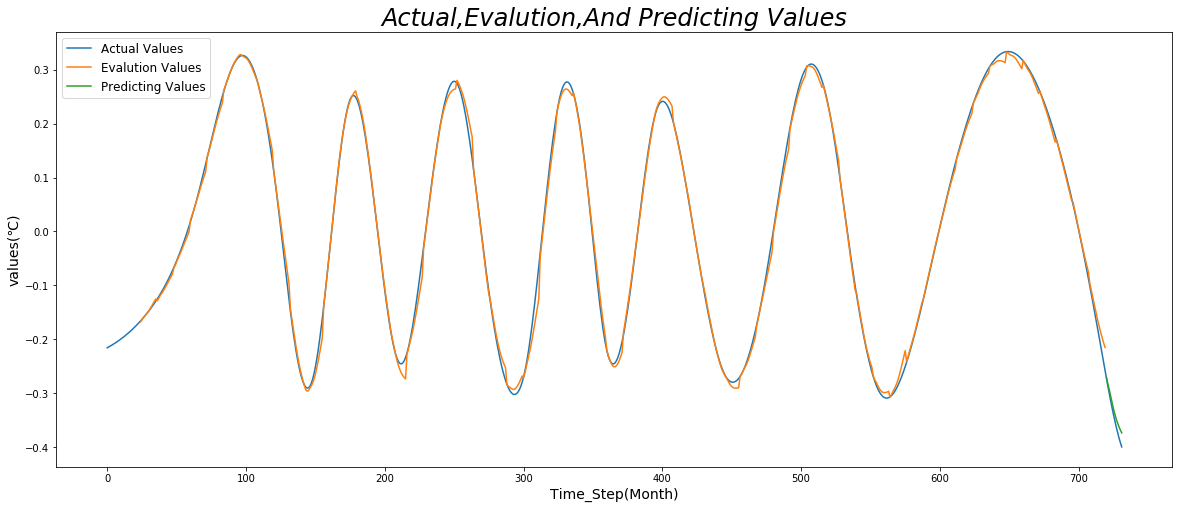

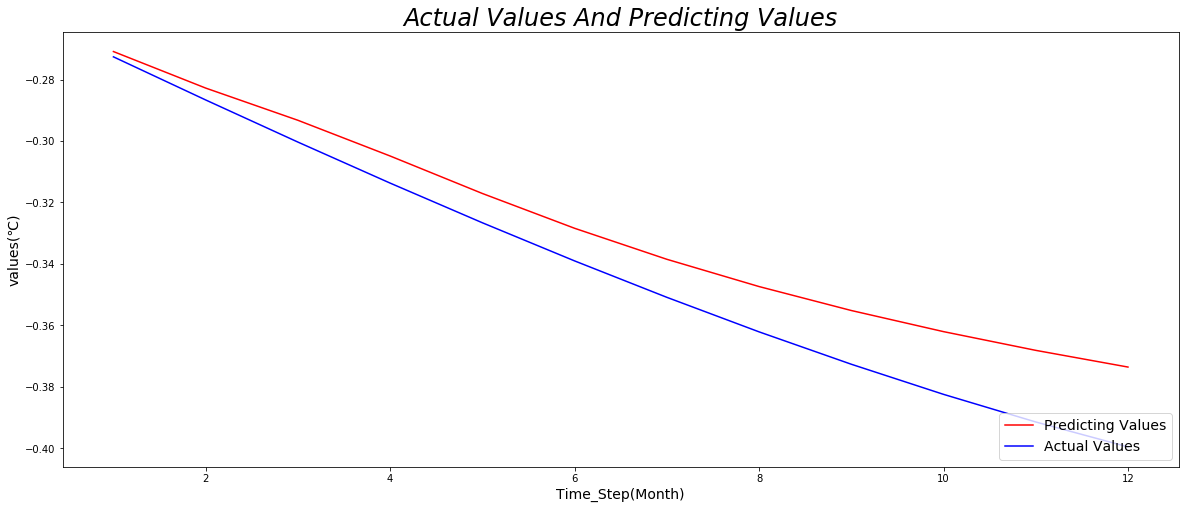

0      0.004482
1      0.003265
2      0.002159
3      0.001161
4      0.000266
5     -0.000529
6     -0.001226
7     -0.001830
8     -0.002343
9     -0.002768
10    -0.003109
11    -0.003368
12    -0.003548
13    -0.003654
14    -0.003686
15    -0.003650
16    -0.003548
17    -0.003384
18    -0.003162
19    -0.002884
20    -0.002554
21    -0.002177
22    -0.001754
23    -0.001289
24    -0.000785
25    -0.000244
26     0.000330
27     0.000934
28     0.001566
29     0.002224
         ...   
702   -0.139050
703   -0.137070
704   -0.135030
705   -0.132930
706   -0.130780
707   -0.128560
708   -0.126280
709   -0.123940
710   -0.121550
711   -0.119100
712   -0.116590
713   -0.114030
714   -0.111410
715   -0.108740
716   -0.106020
717   -0.103240
718   -0.100420
719   -0.097538
720   -0.094611
721   -0.091635
722   -0.088610
723   -0.085538
724   -0.082419
725   -0.079254
726   -0.076044
727   -0.072789
728   -0.069490
729   -0.066149
730   -0.062766
731   -0.059341
Name: f5, Length: 732, d

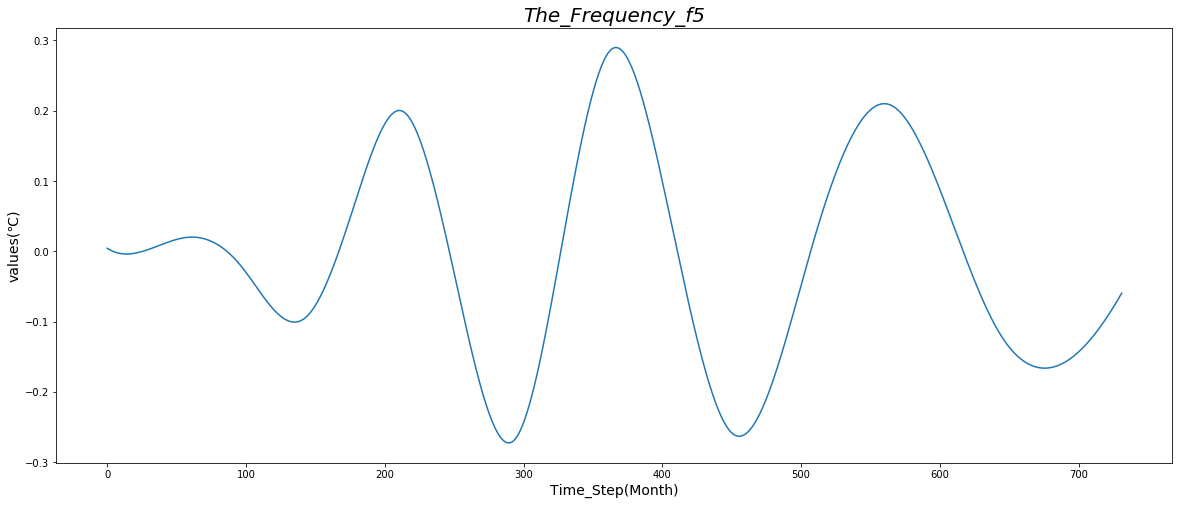

[[[ 4.4815e-03]
  [ 3.2649e-03]
  [ 2.1594e-03]
  [ 1.1610e-03]
  [ 2.6607e-04]
  [-5.2874e-04]
  [-1.2265e-03]
  [-1.8303e-03]
  [-2.3432e-03]
  [-2.7684e-03]
  [-3.1089e-03]
  [-3.3678e-03]]

 [[-3.5483e-03]
  [-3.6535e-03]
  [-3.6864e-03]
  [-3.6501e-03]
  [-3.5482e-03]
  [-3.3842e-03]
  [-3.1616e-03]
  [-2.8838e-03]
  [-2.5544e-03]
  [-2.1766e-03]
  [-1.7537e-03]
  [-1.2888e-03]]

 [[-7.8468e-04]
  [-2.4422e-04]
  [ 3.2968e-04]
  [ 9.3417e-04]
  [ 1.5665e-03]
  [ 2.2240e-03]
  [ 2.9039e-03]
  [ 3.6035e-03]
  [ 4.3202e-03]
  [ 5.0511e-03]
  [ 5.7937e-03]
  [ 6.5452e-03]]

 [[ 7.3028e-03]
  [ 8.0640e-03]
  [ 8.8259e-03]
  [ 9.5859e-03]
  [ 1.0341e-02]
  [ 1.1089e-02]
  [ 1.1827e-02]
  [ 1.2552e-02]
  [ 1.3262e-02]
  [ 1.3954e-02]
  [ 1.4624e-02]
  [ 1.5271e-02]]

 [[ 1.5892e-02]
  [ 1.6484e-02]
  [ 1.7044e-02]
  [ 1.7570e-02]
  [ 1.8058e-02]
  [ 1.8507e-02]
  [ 1.8913e-02]
  [ 1.9274e-02]
  [ 1.9587e-02]
  [ 1.9850e-02]
  [ 2.0061e-02]
  [ 2.0217e-02]]

 [[ 2.0317e-02]
  [ 2.0360e-02

Epoch 1/200
 - 11s - loss: 0.0140
Epoch 2/200
 - 2s - loss: 0.0067
Epoch 3/200
 - 2s - loss: 0.0028
Epoch 4/200
 - 2s - loss: 0.0011
Epoch 5/200
 - 2s - loss: 3.4885e-04
Epoch 6/200
 - 2s - loss: 1.7557e-04
Epoch 7/200
 - 2s - loss: 1.4395e-04
Epoch 8/200
 - 2s - loss: 1.6526e-04
Epoch 9/200
 - 2s - loss: 1.8829e-04
Epoch 10/200
 - 2s - loss: 1.1287e-04
Epoch 11/200
 - 2s - loss: 7.6249e-05
Epoch 12/200
 - 2s - loss: 8.3640e-05
Epoch 13/200
 - 3s - loss: 7.0382e-05
Epoch 14/200
 - 2s - loss: 1.3099e-04
Epoch 15/200
 - 2s - loss: 1.2996e-04
Epoch 16/200
 - 2s - loss: 8.2175e-05
Epoch 17/200
 - 2s - loss: 9.8368e-05
Epoch 18/200
 - 2s - loss: 5.6437e-05
Epoch 19/200
 - 2s - loss: 4.6686e-05
Epoch 20/200
 - 2s - loss: 5.2123e-05
Epoch 21/200
 - 2s - loss: 4.7497e-05
Epoch 22/200
 - 2s - loss: 5.8896e-05
Epoch 23/200
 - 2s - loss: 6.0021e-05
Epoch 24/200
 - 2s - loss: 4.3786e-05
Epoch 25/200
 - 2s - loss: 4.2855e-05
Epoch 26/200
 - 2s - loss: 4.4945e-05
Epoch 27/200
 - 2s - loss: 6.3663e-0

(58, 12)


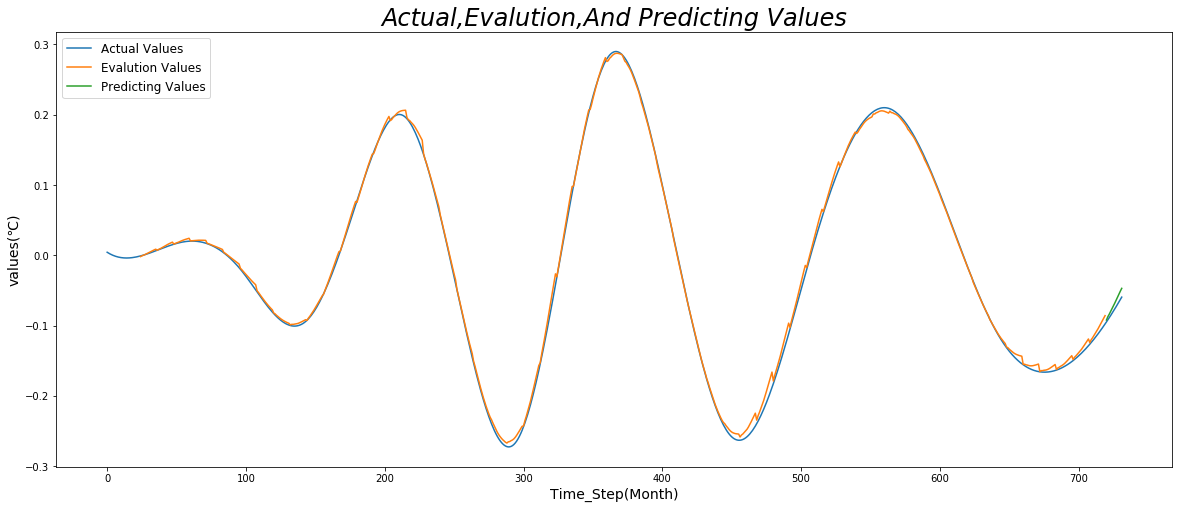

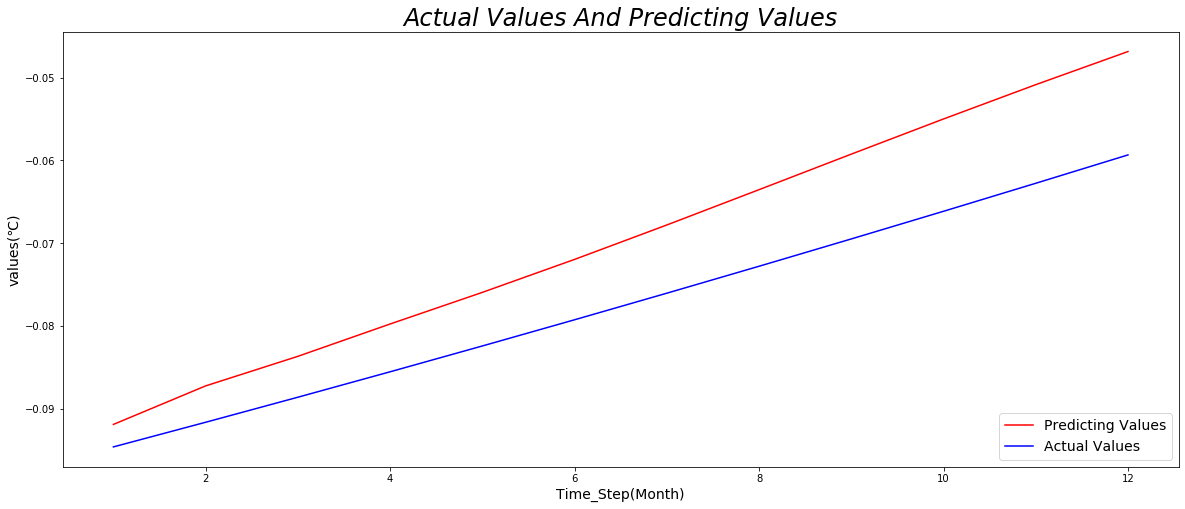

0     -0.12887
1     -0.12956
2     -0.13022
3     -0.13084
4     -0.13142
5     -0.13198
6     -0.13249
7     -0.13297
8     -0.13342
9     -0.13382
10    -0.13418
11    -0.13451
12    -0.13479
13    -0.13504
14    -0.13524
15    -0.13539
16    -0.13551
17    -0.13557
18    -0.13559
19    -0.13557
20    -0.13549
21    -0.13536
22    -0.13519
23    -0.13496
24    -0.13468
25    -0.13434
26    -0.13395
27    -0.13351
28    -0.13302
29    -0.13247
        ...   
702   -0.21087
703   -0.21017
704   -0.20945
705   -0.20870
706   -0.20794
707   -0.20715
708   -0.20634
709   -0.20552
710   -0.20467
711   -0.20380
712   -0.20292
713   -0.20201
714   -0.20109
715   -0.20014
716   -0.19918
717   -0.19821
718   -0.19721
719   -0.19620
720   -0.19517
721   -0.19413
722   -0.19307
723   -0.19199
724   -0.19091
725   -0.18980
726   -0.18868
727   -0.18755
728   -0.18641
729   -0.18525
730   -0.18408
731   -0.18290
Name: f6, Length: 732, dtype: float64
(732,)


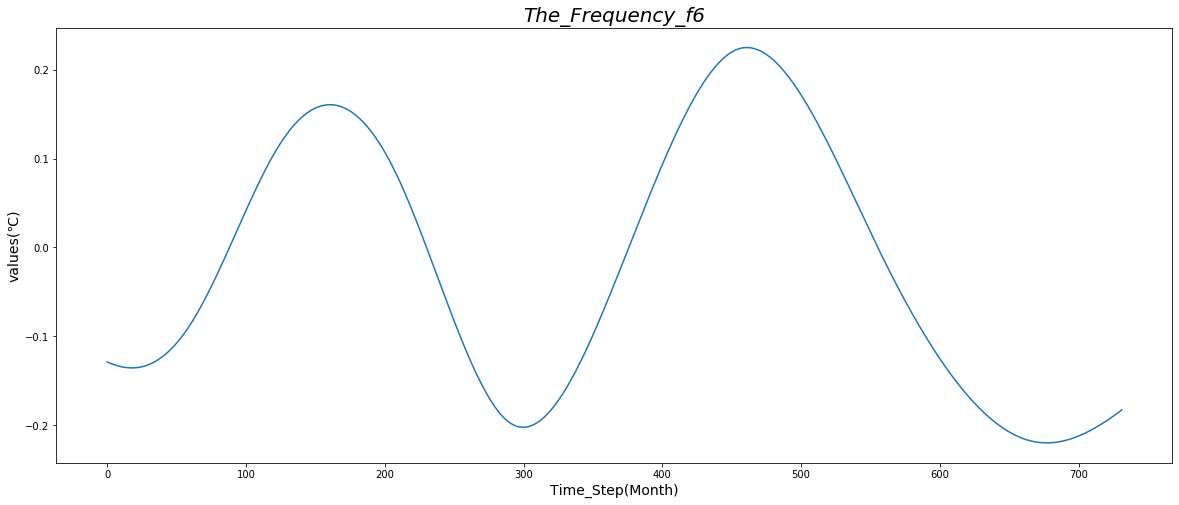

[[[-0.12887   ]
  [-0.12956   ]
  [-0.13022   ]
  [-0.13084   ]
  [-0.13142   ]
  [-0.13198   ]
  [-0.13249   ]
  [-0.13297   ]
  [-0.13342   ]
  [-0.13382   ]
  [-0.13418   ]
  [-0.13451   ]]

 [[-0.13479   ]
  [-0.13504   ]
  [-0.13524   ]
  [-0.13539   ]
  [-0.13551   ]
  [-0.13557   ]
  [-0.13559   ]
  [-0.13557   ]
  [-0.13549   ]
  [-0.13536   ]
  [-0.13519   ]
  [-0.13496   ]]

 [[-0.13468   ]
  [-0.13434   ]
  [-0.13395   ]
  [-0.13351   ]
  [-0.13302   ]
  [-0.13247   ]
  [-0.13187   ]
  [-0.13121   ]
  [-0.13049   ]
  [-0.12972   ]
  [-0.12889   ]
  [-0.12801   ]]

 [[-0.12707   ]
  [-0.12608   ]
  [-0.12502   ]
  [-0.12391   ]
  [-0.12274   ]
  [-0.12151   ]
  [-0.12022   ]
  [-0.11888   ]
  [-0.11747   ]
  [-0.116     ]
  [-0.11448   ]
  [-0.11289   ]]

 [[-0.11124   ]
  [-0.10953   ]
  [-0.10776   ]
  [-0.10593   ]
  [-0.10404   ]
  [-0.10208   ]
  [-0.10006   ]
  [-0.097974  ]
  [-0.095827  ]
  [-0.093616  ]
  [-0.091342  ]
  [-0.089005  ]]

 [[-0.086605  ]
  [-0.084145  

Epoch 1/200
 - 12s - loss: 0.0099
Epoch 2/200
 - 2s - loss: 0.0036
Epoch 3/200
 - 2s - loss: 0.0017
Epoch 4/200
 - 2s - loss: 6.7010e-04
Epoch 5/200
 - 2s - loss: 3.3100e-04
Epoch 6/200
 - 2s - loss: 1.2220e-04
Epoch 7/200
 - 2s - loss: 4.2542e-05
Epoch 8/200
 - 2s - loss: 3.0588e-05
Epoch 9/200
 - 2s - loss: 2.2035e-05
Epoch 10/200
 - 2s - loss: 1.6046e-05
Epoch 11/200
 - 2s - loss: 1.9321e-05
Epoch 12/200
 - 2s - loss: 2.0987e-05
Epoch 13/200
 - 2s - loss: 1.7214e-05
Epoch 14/200
 - 2s - loss: 1.2765e-05
Epoch 15/200
 - 2s - loss: 7.6819e-05
Epoch 16/200
 - 2s - loss: 1.7215e-04
Epoch 17/200
 - 2s - loss: 4.6299e-05
Epoch 18/200
 - 2s - loss: 1.4784e-05
Epoch 19/200
 - 2s - loss: 9.8087e-06
Epoch 20/200
 - 2s - loss: 1.2550e-05
Epoch 21/200
 - 2s - loss: 1.3986e-05
Epoch 22/200
 - 2s - loss: 8.6792e-06
Epoch 23/200
 - 2s - loss: 1.2832e-05
Epoch 24/200
 - 2s - loss: 1.0339e-05
Epoch 25/200
 - 2s - loss: 1.6201e-05
Epoch 26/200
 - 2s - loss: 1.3024e-05
Epoch 27/200
 - 2s - loss: 2.648

(58, 12)


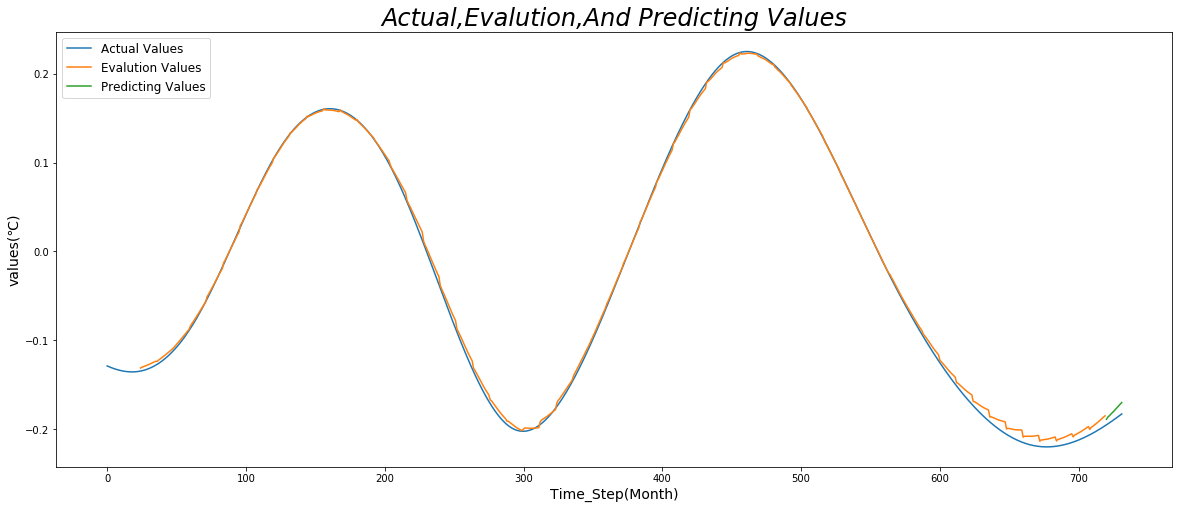

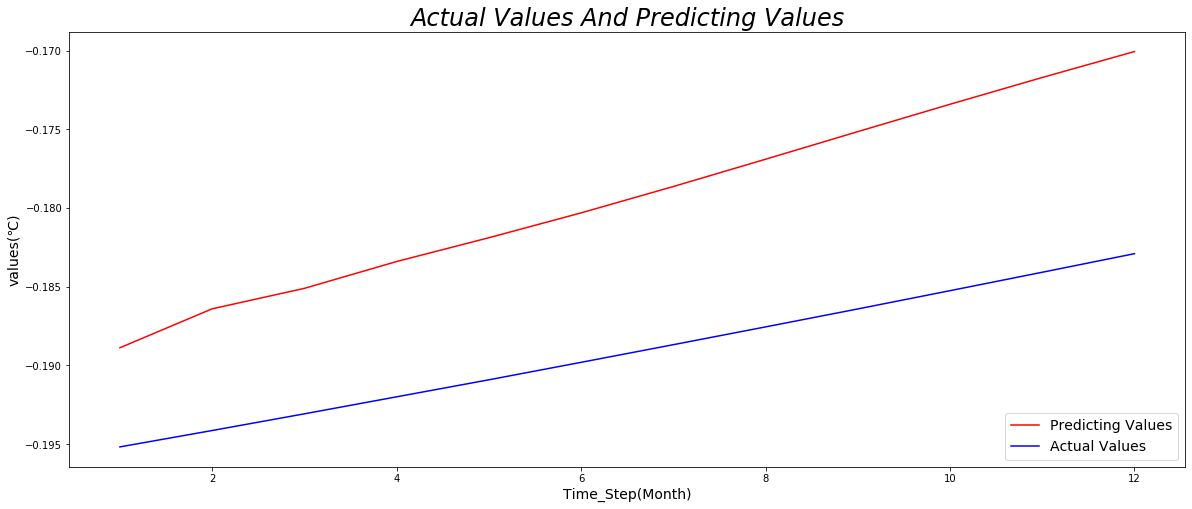

0      0.051841
1      0.051858
2      0.051870
3      0.051877
4      0.051878
5      0.051875
6      0.051866
7      0.051851
8      0.051832
9      0.051807
10     0.051776
11     0.051741
12     0.051700
13     0.051653
14     0.051601
15     0.051543
16     0.051480
17     0.051411
18     0.051337
19     0.051257
20     0.051172
21     0.051081
22     0.050984
23     0.050882
24     0.050774
25     0.050660
26     0.050542
27     0.050418
28     0.050288
29     0.050153
         ...   
702    0.044283
703    0.044283
704    0.044279
705    0.044273
706    0.044263
707    0.044251
708    0.044236
709    0.044218
710    0.044197
711    0.044174
712    0.044147
713    0.044118
714    0.044086
715    0.044051
716    0.044013
717    0.043973
718    0.043930
719    0.043884
720    0.043835
721    0.043784
722    0.043730
723    0.043673
724    0.043614
725    0.043552
726    0.043487
727    0.043420
728    0.043350
729    0.043278
730    0.043203
731    0.043125
Name: f7, Length: 732, d

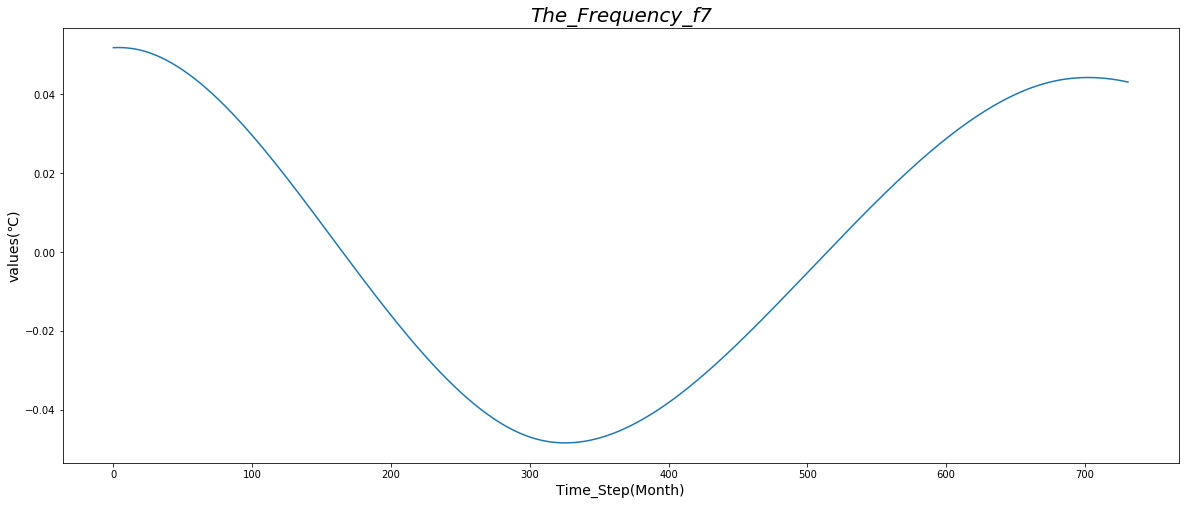

[[[ 5.1841e-02]
  [ 5.1858e-02]
  [ 5.1870e-02]
  [ 5.1877e-02]
  [ 5.1878e-02]
  [ 5.1875e-02]
  [ 5.1866e-02]
  [ 5.1851e-02]
  [ 5.1832e-02]
  [ 5.1807e-02]
  [ 5.1776e-02]
  [ 5.1741e-02]]

 [[ 5.1700e-02]
  [ 5.1653e-02]
  [ 5.1601e-02]
  [ 5.1543e-02]
  [ 5.1480e-02]
  [ 5.1411e-02]
  [ 5.1337e-02]
  [ 5.1257e-02]
  [ 5.1172e-02]
  [ 5.1081e-02]
  [ 5.0984e-02]
  [ 5.0882e-02]]

 [[ 5.0774e-02]
  [ 5.0660e-02]
  [ 5.0542e-02]
  [ 5.0418e-02]
  [ 5.0288e-02]
  [ 5.0153e-02]
  [ 5.0013e-02]
  [ 4.9868e-02]
  [ 4.9718e-02]
  [ 4.9562e-02]
  [ 4.9402e-02]
  [ 4.9236e-02]]

 [[ 4.9065e-02]
  [ 4.8889e-02]
  [ 4.8709e-02]
  [ 4.8523e-02]
  [ 4.8333e-02]
  [ 4.8138e-02]
  [ 4.7938e-02]
  [ 4.7733e-02]
  [ 4.7524e-02]
  [ 4.7310e-02]
  [ 4.7091e-02]
  [ 4.6868e-02]]

 [[ 4.6640e-02]
  [ 4.6408e-02]
  [ 4.6171e-02]
  [ 4.5930e-02]
  [ 4.5685e-02]
  [ 4.5435e-02]
  [ 4.5181e-02]
  [ 4.4923e-02]
  [ 4.4660e-02]
  [ 4.4394e-02]
  [ 4.4123e-02]
  [ 4.3848e-02]]

 [[ 4.3570e-02]
  [ 4.3287e-02

Epoch 1/200
 - 13s - loss: 9.0555e-04
Epoch 2/200
 - 2s - loss: 2.7430e-04
Epoch 3/200
 - 2s - loss: 1.4626e-04
Epoch 4/200
 - 2s - loss: 9.9349e-05
Epoch 5/200
 - 2s - loss: 6.8064e-05
Epoch 6/200
 - 2s - loss: 5.4884e-05
Epoch 7/200
 - 2s - loss: 4.7142e-05
Epoch 8/200
 - 2s - loss: 4.4061e-05
Epoch 9/200
 - 2s - loss: 3.5669e-05
Epoch 10/200
 - 2s - loss: 2.8001e-05
Epoch 11/200
 - 2s - loss: 3.1016e-05
Epoch 12/200
 - 2s - loss: 2.5140e-05
Epoch 13/200
 - 3s - loss: 2.6776e-05
Epoch 14/200
 - 3s - loss: 2.2677e-05
Epoch 15/200
 - 2s - loss: 2.0606e-05
Epoch 16/200
 - 2s - loss: 3.0981e-05
Epoch 17/200
 - 2s - loss: 2.1265e-05
Epoch 18/200
 - 2s - loss: 1.2784e-05
Epoch 19/200
 - 2s - loss: 1.0646e-05
Epoch 20/200
 - 2s - loss: 1.0086e-05
Epoch 21/200
 - 2s - loss: 4.6814e-06
Epoch 22/200
 - 2s - loss: 2.8983e-06
Epoch 23/200
 - 2s - loss: 2.5062e-06
Epoch 24/200
 - 3s - loss: 1.6950e-06
Epoch 25/200
 - 2s - loss: 1.0271e-06
Epoch 26/200
 - 2s - loss: 1.1789e-06
Epoch 27/200
 - 2s -

(58, 12)


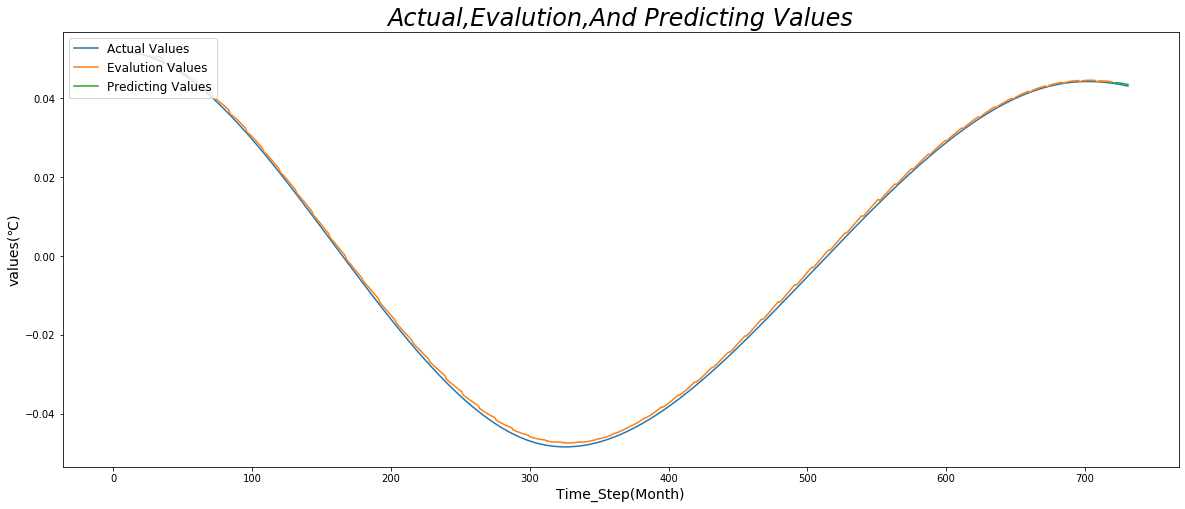

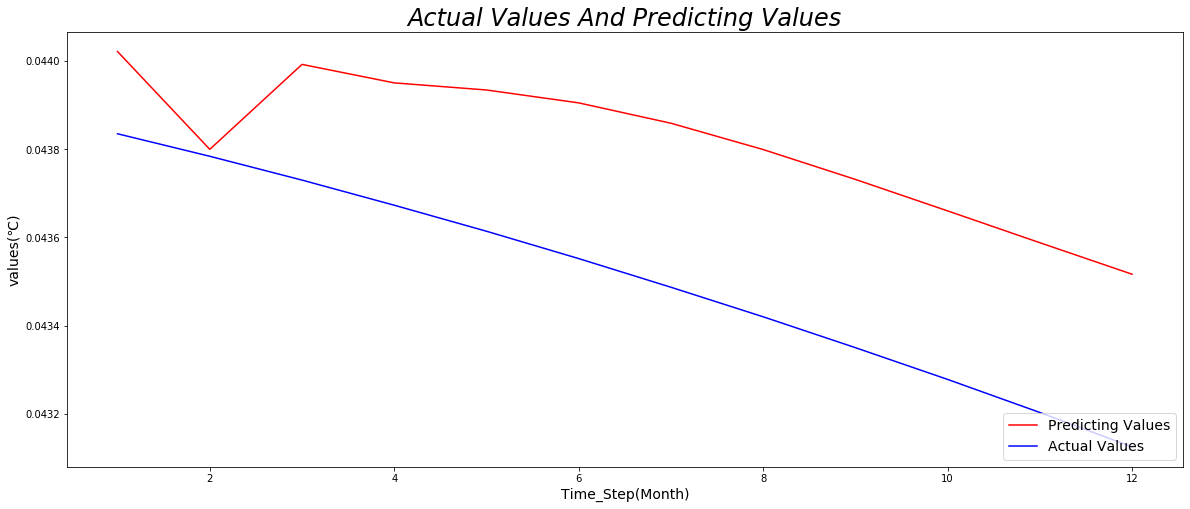

0      0.085791
1      0.085784
2      0.085777
3      0.085769
4      0.085762
5      0.085755
6      0.085747
7      0.085740
8      0.085733
9      0.085725
10     0.085718
11     0.085710
12     0.085703
13     0.085695
14     0.085687
15     0.085680
16     0.085672
17     0.085664
18     0.085657
19     0.085649
20     0.085641
21     0.085633
22     0.085625
23     0.085618
24     0.085610
25     0.085602
26     0.085594
27     0.085586
28     0.085578
29     0.085570
         ...   
702    0.078168
703    0.078161
704    0.078154
705    0.078146
706    0.078139
707    0.078132
708    0.078125
709    0.078118
710    0.078111
711    0.078104
712    0.078098
713    0.078091
714    0.078084
715    0.078077
716    0.078070
717    0.078064
718    0.078057
719    0.078050
720    0.078044
721    0.078037
722    0.078030
723    0.078024
724    0.078017
725    0.078011
726    0.078005
727    0.077998
728    0.077992
729    0.077985
730    0.077979
731    0.077973
Name: f8, Length: 732, d

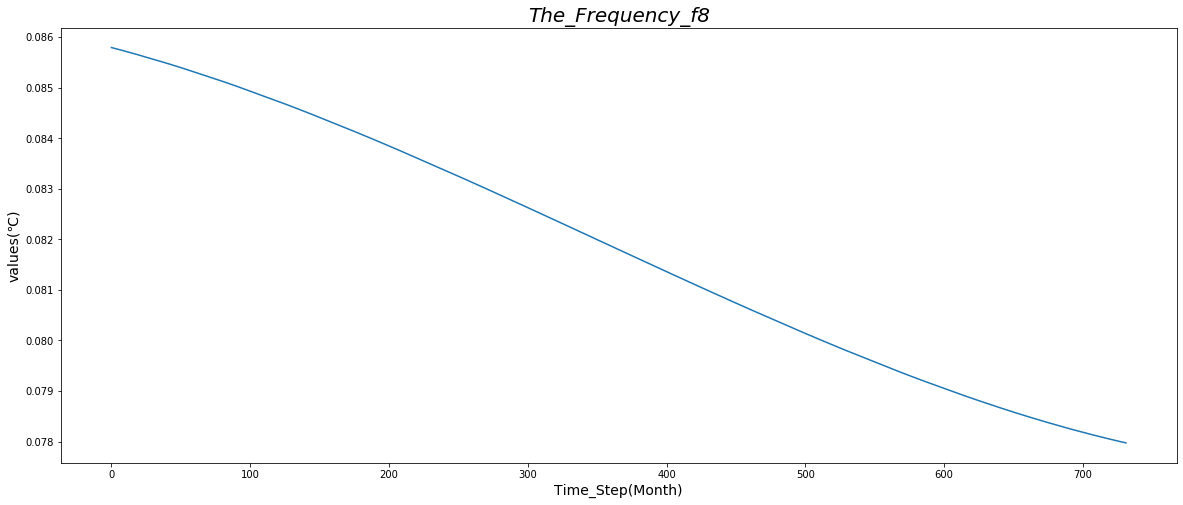

[[[0.085791]
  [0.085784]
  [0.085777]
  [0.085769]
  [0.085762]
  [0.085755]
  [0.085747]
  [0.08574 ]
  [0.085733]
  [0.085725]
  [0.085718]
  [0.08571 ]]

 [[0.085703]
  [0.085695]
  [0.085687]
  [0.08568 ]
  [0.085672]
  [0.085664]
  [0.085657]
  [0.085649]
  [0.085641]
  [0.085633]
  [0.085625]
  [0.085618]]

 [[0.08561 ]
  [0.085602]
  [0.085594]
  [0.085586]
  [0.085578]
  [0.08557 ]
  [0.085562]
  [0.085554]
  [0.085545]
  [0.085537]
  [0.085529]
  [0.085521]]

 [[0.085513]
  [0.085504]
  [0.085496]
  [0.085488]
  [0.085479]
  [0.085471]
  [0.085463]
  [0.085454]
  [0.085446]
  [0.085437]
  [0.085429]
  [0.08542 ]]

 [[0.085411]
  [0.085403]
  [0.085394]
  [0.085386]
  [0.085377]
  [0.085368]
  [0.085359]
  [0.085351]
  [0.085342]
  [0.085333]
  [0.085324]
  [0.085315]]

 [[0.085306]
  [0.085297]
  [0.085289]
  [0.08528 ]
  [0.085271]
  [0.085262]
  [0.085252]
  [0.085243]
  [0.085234]
  [0.085225]
  [0.085216]
  [0.085207]]

 [[0.085198]
  [0.085188]
  [0.085179]
  [0.08517 ]


Epoch 1/200
 - 14s - loss: 5.9074e-04
Epoch 2/200
 - 3s - loss: 1.4486e-05
Epoch 3/200
 - 3s - loss: 7.7521e-06
Epoch 4/200
 - 3s - loss: 6.1388e-06
Epoch 5/200
 - 3s - loss: 5.7193e-06
Epoch 6/200
 - 3s - loss: 6.3651e-06
Epoch 7/200
 - 3s - loss: 6.2976e-06
Epoch 8/200
 - 3s - loss: 5.9660e-06
Epoch 9/200
 - 3s - loss: 5.7192e-06
Epoch 10/200
 - 3s - loss: 6.2870e-06
Epoch 11/200
 - 3s - loss: 5.5253e-06
Epoch 12/200
 - 3s - loss: 6.0514e-06
Epoch 13/200
 - 3s - loss: 5.6433e-06
Epoch 14/200
 - 3s - loss: 5.5954e-06
Epoch 15/200
 - 3s - loss: 5.4524e-06
Epoch 16/200
 - 3s - loss: 5.3952e-06
Epoch 17/200
 - 3s - loss: 5.7019e-06
Epoch 18/200
 - 3s - loss: 5.3962e-06
Epoch 19/200
 - 3s - loss: 5.6104e-06
Epoch 20/200
 - 3s - loss: 5.5246e-06
Epoch 21/200
 - 3s - loss: 5.3829e-06
Epoch 22/200
 - 3s - loss: 5.3462e-06
Epoch 23/200
 - 3s - loss: 6.4744e-06
Epoch 24/200
 - 3s - loss: 6.2434e-06
Epoch 25/200
 - 3s - loss: 7.5618e-06
Epoch 26/200
 - 3s - loss: 5.8976e-06
Epoch 27/200
 - 3s -

(58, 12)


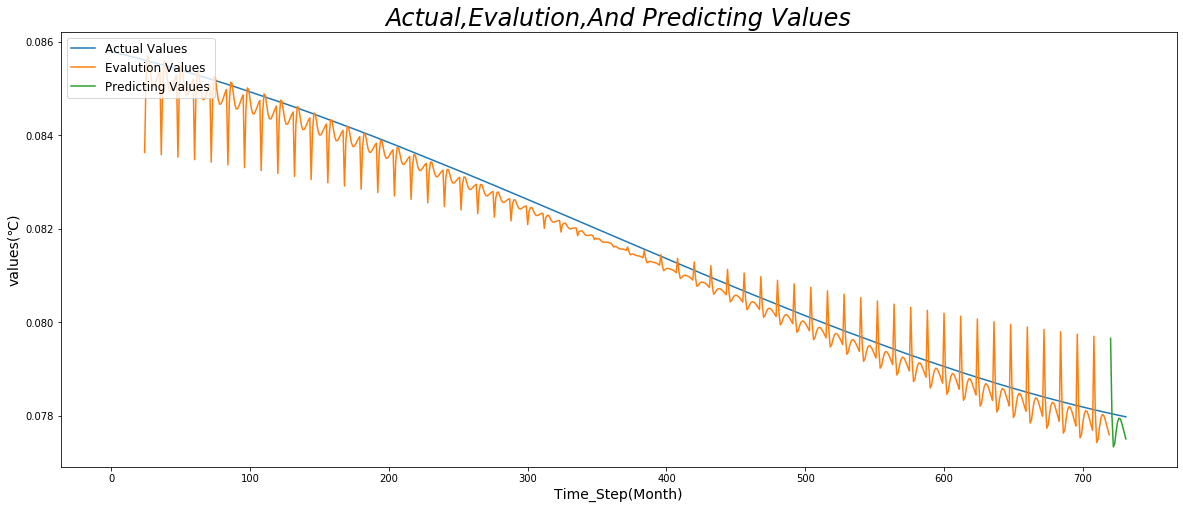

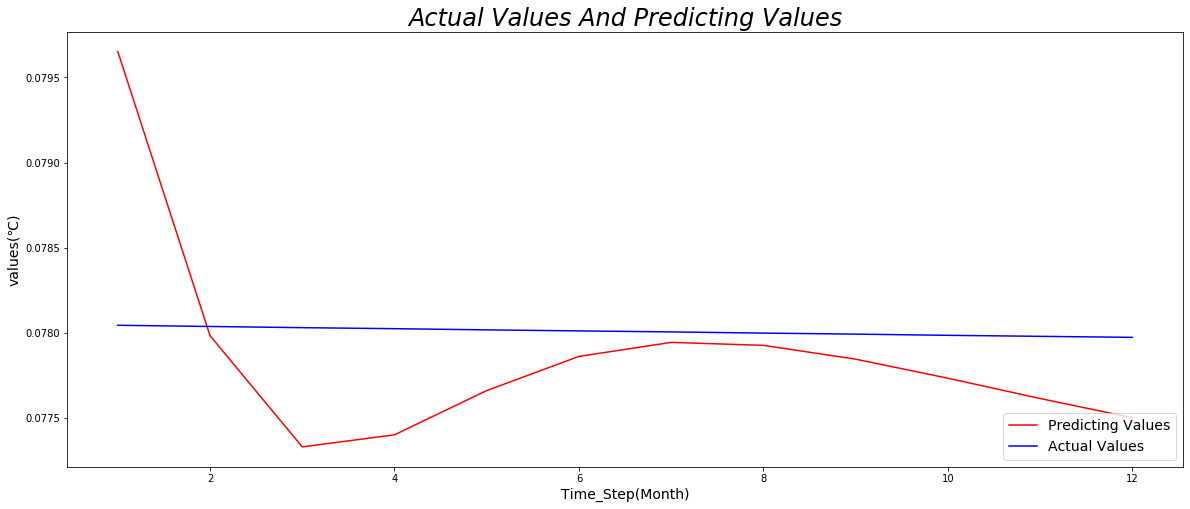

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-96]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)

    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.0796525 ]
 [0.07798298]
 [0.07732935]
 [0.07740027]
 [0.0776604 ]
 [0.07786101]
 [0.07794353]
 [0.07792602]
 [0.07784493]
 [0.07773302]
 [0.0776136 ]
 [0.07750092]]
[array([ 0.43136 ,  0.436   ,  0.30437 ,  0.11433 , -0.056745, -0.2315  ,
       -0.33256 , -0.48256 , -0.50144 , -0.49578 , -0.4587  , -0.37735 ]), array([ 0.51384 ,  0.40337 ,  0.25116 ,  0.074913, -0.10717 , -0.2769  ,
       -0.41605 , -0.50644 , -0.53256 , -0.49206 , -0.39524 , -0.25782 ]), array([ 0.86033,  0.79815,  0.71602,  0.61767,  0.50684,  0.38725,
        0.26266,  0.13679,  0.01337, -0.10405, -0.21276, -0.31057]), array([ 0.13498  ,  0.11305  ,  0.08871  ,  0.062607 ,  0.035372 ,
        0.0076416, -0.01995  , -0.046766 , -0.072172 , -0.095532 ,
       -0.11621  , -0.13357  ]), array([-0.2726 , -0.28663, -0.30034, -0.31369, -0.3266 , -0.33901,
       -0.35086, -0.3621 , -0.37264, -0.38244, -0.39143, -0.39954]), array([-0.094611, -0.091635, -0.08861 , -0.085538, -0.082419, -0.079254,
       -0.076044, -0.0

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[ 0.43136   0.436     0.30437   0.11433  -0.056745 -0.2315   -0.33256
 -0.48256  -0.50144  -0.49578  -0.4587   -0.37735 ]
[[ 0.43136 ]
 [ 0.436   ]
 [ 0.30437 ]
 [ 0.11433 ]
 [-0.056745]
 [-0.2315  ]
 [-0.33256 ]
 [-0.48256 ]
 [-0.50144 ]
 [-0.49578 ]
 [-0.4587  ]
 [-0.37735 ]]
[[ 0.43]
 [ 0.44]
 [ 0.3 ]
 [ 0.11]
 [-0.06]
 [-0.23]
 [-0.33]
 [-0.48]
 [-0.5 ]
 [-0.5 ]
 [-0.46]
 [-0.38]]
-----------------------------------
observe value:[ 0.51384   0.40337   0.25116   0.074913 -0.10717  -0.2769   -0.41605
 -0.50644  -0.53256  -0.49206  -0.39524  -0.25782 ]
[[ 0.9452  ]
 [ 0.83937 ]
 [ 0.55553 ]
 [ 0.189243]
 [-0.163915]
 [-0.5084  ]
 [-0.74861 ]
 [-0.989   ]
 [-1.034   ]
 [-0.98784 ]
 [-0.85394 ]
 [-0.63517 ]]
[[ 0.95]
 [ 0.84]
 [ 0.56]
 [ 0.19]
 [-0.16]
 [-0.51]
 [-0.75]
 [-0.99]
 [-1.03]
 [-0.99]
 [-0.85]
 [-0.64]]
-----------------------------------
observe value:[ 0.86033  0.79815  0.71602  0.61767  0.50684  0.38725  0.26266  0.13679
  0.01337 -0.10405 -0.21276 -0.31057]

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[ 0.391565    0.33303452  0.3557471   0.2740042  -0.03173695 -0.40220365
 -0.5157567  -0.36954376 -0.13385136  0.07391809  0.18523939  0.19049405]
[ 0.391565    0.33303452  0.3557471   0.27400419 -0.03173695 -0.40220365
 -0.51575673 -0.36954376 -0.13385136  0.07391809  0.18523939  0.19049405]
the 1 frequence:
predicted_value:[ 0.5808897   0.4962807   0.3799297   0.20396803 -0.01662624 -0.24970175
 -0.46086514 -0.6109122  -0.66255194 -0.59957707 -0.43981478 -0.22360119]
[ 0.9724547   0.82931522  0.7356768   0.47797222 -0.04836319 -0.6519054
 -0.97662187 -0.98045596 -0.7964033  -0.52565898 -0.25457539 -0.03310715]
the 2 frequence:
predicted_value:[ 0.878384    0.8078507   0.70893914  0.60630023  0.48884976  0.3674526
  0.24321292  0.12253679  0.0130849  -0.07704985 -0.13998613 -0.16901504]
[ 1.85083869  1.63716593  1.44461593  1.08427246  0.44048657 -0.28445281
 -0.73340894 -0.85791917 -0.78331841 -0.60270883 -0.39456

[[ 1.5]
 [ 1.3]
 [ 0.9]
 [ 0.4]
 [-0.1]
 [-0.6]
 [-1. ]
 [-1.4]
 [-1.6]
 [-1.7]
 [-1.7]
 [-1.6]]
[ 1.55743377  1.3182525   1.09763695  0.70297948  0.02142704 -0.74120587
 -1.2257248  -1.38218993 -1.33461861 -1.17484555 -0.98021823 -0.79320184]


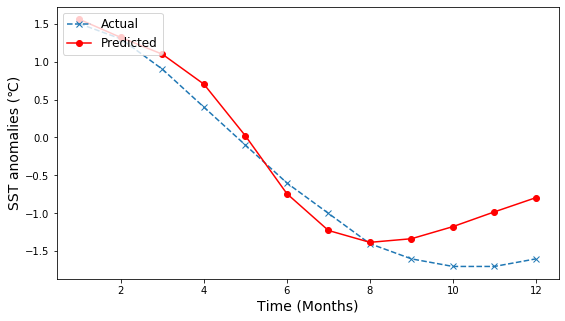

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 
